## Final Code

#### Goal: Understand Dark Matter halo evolution for MW and M31 merger

In this code the focus will be to plot how the circular velocity for the halo of MW and M31 changes through the merger. 

Plan for aditional plot will be provided that shows the how ASAM (or spin paramater, if time allows) evolves during the merger.

#### Plot 1

plot halo circular velocity profile 

In [1]:
# import modules
import numpy as np
import astropy.units as u

import matplotlib
import matplotlib.pyplot as plt
import astropy.table as tbl

from ReadFileNew import ReadNew
from CenterOfMassNew import CenterOfMassNew
from Mass_ProfileNew import MassProfileNew
from ReadFile import Read


In [2]:
def RemnantData(galaxy1, galaxy2, snap=800):
        """ Function to concantenate the MW and M31 files and gives array of properties for the remnant.
        Inputs:
            galaxy1: 'string'
                name of galaxy 1 :'MW'
            galaxy2: 'string'
                name of galaxy 2:"M31"
            snap: 'int'
                snap id of the txt file for the galaxies
        """

        # add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        # remove all but last 3 digits
        ilbl = ilbl[-3:]
        filename1 = "%s_"%(galaxy1) + ilbl + '.txt'
        filename2 = "%s_"%(galaxy2) + ilbl + '.txt'

        # read data in the given file using Read
        data1 = ReadNew(filename1,merger=False)
        data2 = ReadNew(filename2,merger=False)

        remdata = np.concatenate((data1, data2))

        # store remnant name as global property
        gname = "MWM31_remnant" #change the name for general galaxy1, and galaxy2
        filename = "%s_"%(gname) + ilbl + '.txt'
       
        np.savetxt(filename, remdata, fmt = "%15.5f"*8, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('type','m', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        return remdata

In [3]:
# Create data file for remnant galaxy
remdata = RemnantData("txtfiles/MW", "txtfiles/M31", 800)

In [2]:
#Initiate classes
MW = MassProfileNew("txtfiles/MW", 0, merger=False) 
M31 = MassProfileNew("txtfiles/M31", 0)

MW_end = MassProfileNew("txtfiles/MW", 800, merger=False) 
M31_end = MassProfileNew("txtfiles/M31", 800, merger=False)

remnant = MassProfileNew("MWM31_remnant",800, merger=True)

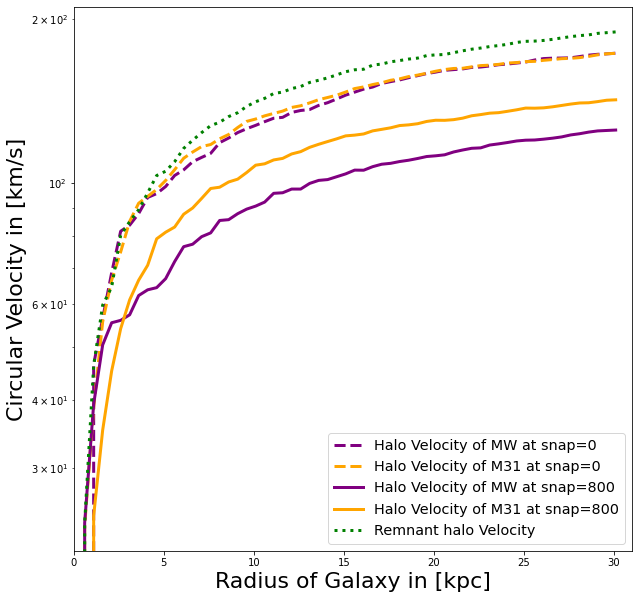

In [3]:
# array for distance
r = np.arange(0.1, 30.5, 0.5) 

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 


# plot MW halo velocity before merger
ax.semilogy(r, MW.CircularVelocity(1, r), color="purple", linestyle="--", 
            linewidth=3, label='Halo Velocity of MW at snap=0')
# plot M31 halo velocity before merger
ax.semilogy(r, M31.CircularVelocity(1, r), color="orange", linestyle="--",
            linewidth=3, label='Halo Velocity of M31 at snap=0')
# plot MW halo velocity after merger
ax.semilogy(r, MW_end.CircularVelocity(1, r), color="purple",
            linewidth=3, label='Halo Velocity of MW at snap=800')
# plot M31 halo velocity after merger
ax.semilogy(r, M31_end.CircularVelocity(1, r), color="orange", 
            linewidth=3, label='Halo Velocity of M31 at snap=800')

# Final Remnant velocity
ax.semilogy(r, remnant.CircularVelocity(1, r), color="green", 
            linestyle=":", linewidth=3, label='Remnant halo Velocity')

# Add labels
plt.xlabel('Radius of Galaxy in [kpc]', fontsize=22)
plt.ylabel(r'Circular Velocity in [km/s]', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#### Plot 2
Average Specific Angular Momentim (ASAM) of galaxy halo

In [4]:
# plot how ASAM changes radially, choose a radius point to compute ASAM within (or half mass)
#commom com for m31 and mw (modifly com function)

class ASAM:

    def __init__(self, galaxy, snap, ptype, merger=False):
        """ Class to compute average specific angular momentum of a 
        galaxy at given snapshot
        
        PARAMETERS
        ----------
        galaxy : `str: "MW", "M31" or "M33"`
            galaxy name 
        snap : `int: 0, 1, etc.`
            snapshot number
        ptype:'int'
            particle type
        merger: 'boolean'
            if the snapshot if for single galaxy or the merger remnant
        """
        # add a string of the filenumber to the alue "000"
        ilbl = '000' + str(snap)
        # remove all but last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        self.ptype = ptype        
        self.merger = merger
        # read data in the given file using Read
        self.data = ReadNew(self.filename, self.merger) # for individual galaxy
        
        self.index = np.where(self.data['type'] == ptype)

        # store the mass, positions, and velocities of all the particles 
        self.m = self.data['m']

        self.x = (self.data['x'])[self.index]
        self.y = (self.data['y'])[self.index]
        self.z = (self.data['z'])[self.index]
        
        self.vx = self.data['vx'][self.index]
        self.vy = self.data['vy'][self.index]
        self.vz = self.data['vz'][self.index]
        
        # store galaxy name as global property
        self.gname = galaxy

    def AvgSpecAngularMomentum (self, radii):
        """ This function computes the specific angular momentum of given 
        particle type in a galaxy.
        
        INPUTS:
        -------
        radii: `array` or `float`
            radii within which ASAM needs to be calculated
       
        OUTPUTS:
        --------
        SAM : `numpy array`
            specific angular momtem for all particles of ptype

        """
        # Initalize CenterOfMass to find the COM values and get relative position
        COMfunction = CenterOfMassNew(self.filename,2.0, self.merger) # for COM position disk particles give best estimate
        COM_P = COMfunction.COM_P(0.1)
        COM_V = COMfunction.COM_V(COM_P[0], COM_P[1], COM_P[2])
        
        # determine the position of all particles relative to the center of mass position (x_COM, y_COM, z_COM)
        xV = (self.x - COM_P[0]/u.kpc) # remove units to perform operations
        yV = (self.y - COM_P[1]/u.kpc)
        zV = (self.z - COM_P[2]/u.kpc)
        r_mag = ((xV**2 + yV**2 + zV**2)**0.5) * u.kpc # add units back
        
        # condition based on type(radii)
        if type(radii) == int:
            length = 1 # when computing ASAM wrt time
        else:
            length = len(radii) # when computing ASAM wrt radius 
            
        # array of 0s to store enclosed SAM value for each radii    
        ASAM = np.zeros(length)
        
        # determine the index for those particles within the max radius
        for i in range(length):
            if type(radii) == int:
                indexV = np.where(r_mag <= radii*u.kpc)
            else:
                indexV = np.where(r_mag <= radii[i]*u.kpc)
        
            # determine the relative velocity and position of those particles
            
            vx_new = self.vx[indexV] - np.repeat(COM_V[0]/(u.km/u.s),len(self.vx[indexV]))
            vy_new = self.vy[indexV] - COM_V[1]/(u.km/u.s)
            vz_new = self.vz[indexV] - COM_V[2]/(u.km/u.s)
            m_new = self.m[indexV] 
            x_new = self.x[indexV] - COM_P[0]/u.kpc
            y_new = self.y[indexV] - COM_P[1]/u.kpc
            z_new = self.z[indexV] - COM_P[2]/u.kpc
        
            # compute array of 'v' for all particles
            # v = [vx, vy, vz]

            v = np.concatenate((vx_new, vy_new, vz_new))
            v_new = np.reshape(v,(-1,len(vx_new))).T

            # compute array of 'r' for all particles
            # r = [x, y, z] 

            r = np.concatenate((x_new, y_new, z_new), axis=0)
            r_new = np.reshape(r,(-1,len(x_new))).T

            # use formula h = r x v, to find specific angular momentum of each particle
            # use np.cross / matrix multiplication
            SAM = (np.cross(r_new,v_new))
            
            # compute the Avergae of all SAM values
            mag = np.zeros(len(SAM))
            index=0
            for val in mag:
                #print(SAM[index])
                mag[index] = np.linalg.norm(SAM[index])
                index += 1
            ASAM[i] = np.average(mag)
            
        return ASAM

    

In [5]:
# Average Specific Angular Momentum of MW before merger
MW_AM = ASAM("txtfiles/MW", snap = 0, ptype = 1, merger = False)
r = np.arange(1, 50, 0.5) 
ASAM_MW = MW_AM.AvgSpecAngularMomentum(r)


In [6]:
# Average Specific Angular Momentum of M31 before merger
M31_AM = ASAM("txtfiles/M31", snap = 0, ptype = 1, merger = False)
ASAM_M31 = M31_AM.AvgSpecAngularMomentum(r)

In [7]:
# Average Specific Angular Momentum of Remnant
Remnant_AM = ASAM("MWM31_remnant", snap = 800, ptype = 1, merger = True)
ASAM_remnant = Remnant_AM.AvgSpecAngularMomentum(r)

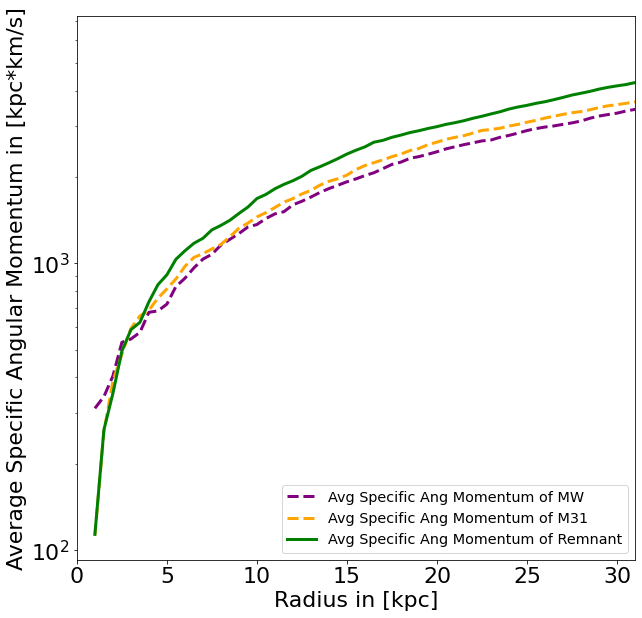

In [8]:
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# plot MW ASAM before merger
ax.semilogy(r, ASAM_MW, color="purple", linestyle="--", 
            linewidth=3, label='Avg Specific Ang Momentum of MW')
# plot M31 ASAM before merger
ax.semilogy(r, ASAM_M31, color="orange", linestyle="--",
            linewidth=3, label='Avg Specific Ang Momentum of M31')
# plot remnant ASAM final
ax.semilogy(r, ASAM_remnant, color="green", 
            linewidth=3, label='Avg Specific Ang Momentum of Remnant')


# Add labels
plt.xlabel('Radius in [kpc]', fontsize=22)
plt.ylabel(r'Average Specific Angular Momentum in [kpc*km/s]', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

Function to create a plot for ASAM to see how it evolves with time.

In [9]:
def ASAM_time(galaxy1, galaxy2,ptype, start, end, n, radii):
    """ Function to determine how the ASAM value of a galaxy evolves with time

    INPUTS:
    --------
    galaxy: `string: "MW", "M31" or "M33"`
        galaxy name
    ptype: `int: 1, 2, 3`
        represents particle typr for the galaxy (halo, disk, bulge)
    start : `float`
        number of the first snapshot to read
    end : `float`
        number of the last snapshot to read
    n : `integer`
        number of intervals to itterate over 

    OUTPUTS:
    ---------
    ASAM_values : `array`
        ASAM value for the galaxy ate each snap shot from 'start' to 'end'

    """
    # compose the filename for output
    fileout = "ASAM_values_MWM31"  + ".txt"

    # minimum interval between snapshots is 1
    if n<1:
        n=1
    # generate the snapshot id sequence    
    snap_ids = np.arange(start, end, n)

    # initialize the array for ASAM info
    # column: time, MW_ASAM, M31_ASAM, Remnant_ASAM
    ASAM_values = np.zeros((len(snap_ids), 4))


    # loop over files
    for i, snap_id in enumerate(snap_ids):
        ilbl = '000' + str(snap_id)
        # remove all but last 3 digits
        ilbl = ilbl[-3:]
        
        filename =  "%s_"%(galaxy1) + ilbl + '.txt'
        ASAM_values[i,0] = Read(filename)[0]/u.Myr
        
        # get ASAM values for MW and M31
        ASAM_function = ASAM(galaxy1, snap_id, ptype, merger=False)
        ASAM_values[i,1] = (ASAM_function.AvgSpecAngularMomentum(radii))
        ASAM_function = ASAM(galaxy2, snap_id, ptype, merger=False)
        ASAM_values[i,2] = (ASAM_function.AvgSpecAngularMomentum(radii))
        
        # get ASAM values for remnant (adding ASAM of MW and M31 in ratio of their masses)
        MassEnc_Gal1 = MassProfileNew(galaxy1, snap_id).MassEnclosed(ptype,radii)
        MassEnc_Gal2 = MassProfileNew(galaxy2, snap_id).MassEnclosed(ptype,radii)
        
        ASAM_values[i,3] = (ASAM_values[i,1]*MassEnc_Gal1 + ASAM_values[i,2]*MassEnc_Gal2)/(MassEnc_Gal1+MassEnc_Gal2)
        
    
    np.savetxt(fileout, ASAM_values, fmt = "%11.3f"*4, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'ASAM_gal1', 'ASAM_gal2', 'ASAM_remnant'))     

In [31]:
# create txt file of ASAM values for all galaxied from snap = 0 to snap =800
r = 30 
ASAM_MW_evol = ASAM_time("txtfiles/MW", "txtfiles/M31",ptype = 1, start=0, end=800, n=5, radii=r)

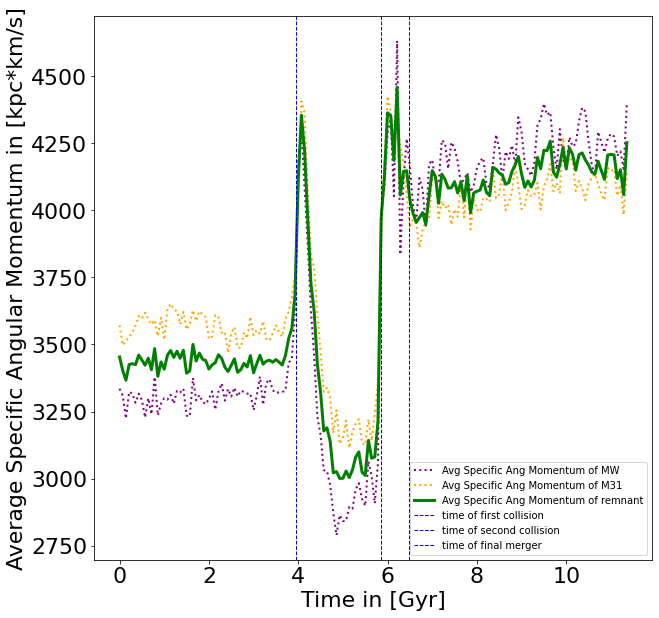

In [10]:
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# read ASAM Evolution txt file
ASAM_evol = np.genfromtxt("ASAM_values_MWM31.txt", dtype=None, names=True)

time = ASAM_evol['t']/1000 # convert to Gyr

# plot MW ASAM evolution
ax.plot(time, ASAM_evol['ASAM_gal1'], color="purple", linestyle=":", 
            linewidth=2, label='Avg Specific Ang Momentum of MW')
# plot M31 ASAM evolution
ax.plot(time, ASAM_evol['ASAM_gal2'], color="orange", linestyle=":",
            linewidth=2, label='Avg Specific Ang Momentum of M31')
# plot remnant ASAM evolution
ax.plot(time, ASAM_evol['ASAM_remnant'], color="green", 
            linewidth=3, label='Avg Specific Ang Momentum of remnant')


# Add labels
plt.xlabel('Time in [Gyr]', fontsize=22)
plt.ylabel(r'Average Specific Angular Momentum in [kpc*km/s]', fontsize=22)

#set time boundaries
plt.axvline(x = 3.957, color = 'b', linestyle="--", linewidth=1, label = 'time of first collision')
plt.axvline(x = 5.857, color = 'b', linestyle="--", linewidth=1, label = 'time of second collision')
plt.axvline(x = 6.486, color = 'b', linestyle="--", linewidth=1, label = 'time of final merger')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='medium')